In [65]:
# Setup notebook enivironment

%matplotlib widget
%config InlineBackend.figure_format = 'retina'


%config Completer.use_jedi = False

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [66]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from skimage import io, measure, segmentation
from pathlib import Path
from scipy import ndimage
from scipy.io import loadmat

# Goal

The goal of the analysis is to identify which labelled nuclei are also IF positive.
- Determine the normalised staining of the (nuclei+/IF+ cells)/area
- Determine the normalised staining of the non nuclear region in (nuclei+/IF+ cells)
- Determine the normalised staining of the nuclear region in (nuclei+/IF+ cells)


# Strategy

The DAPI signal that define the nuclei has been collected in Cyc01R and Cyc11R_IF but segmented only on Cyc01R.   
The IF signal has been collected and segmented in Cyc11R_IF therefore it needs to be registered to Cyc01R.

__STEP1__: register the IF label image Cyc11R_IF to Cyc01R   
__STEP2__: Identify the nuclei+/IF+ cells using the following criteria: _a cell is considered nuclei+/IF+ if the area of the overlapping region is >= the area of the nuclei_



## Questions

# Define working directories

In [12]:
# Define the working directories
data_path = Path('/data/opticalbiosystems.com/Marcos Otero - 2021-06-21_Stf1-Subset_Simone')
nuclei_data_path = data_path / 'Cyc01R'
IF_data_path = data_path / 'Cyc11R_IF'


segmentation_nuclei_path = nuclei_data_path / 'StarDistSegResults_v8.1'
segmentation_IF_path = IF_data_path / 'Segmentation_IF_watershed'


# Data exploration

In order to better understand the data I will look into the data provided by Marcos

## Load the segmented map of the nuclei

.mdat in StarDist output folder of cycle 1 in Marcos' data  
- This is the Segmentation label map in which the segmented objects are labeled with the local object ID.  Non-object (background) is labeled as "0".  
- Just raw data format: there is no header, no other information than pixel data 
- 4-byte unsigned integer per pixel
- 5464x5464 pixels in Marcos' data.  So, 5464x5464x4 = 119,421,184 bytes in file size
- Please load this data using binary file read function like fread() in C language.

In [13]:
nuclei_masks_img = np.fromfile(segmentation_nuclei_path / 'BP27_NucleiMap.mdat', dtype='<i4').reshape(5464,5464)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
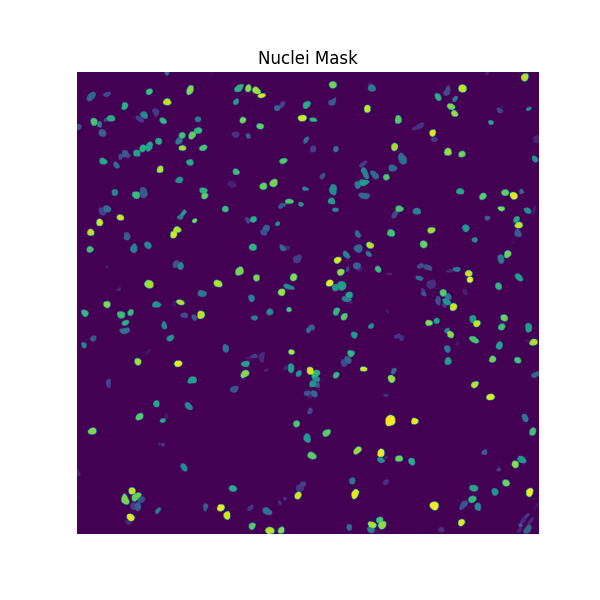

In [125]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
ax.axis('off')
ax.set_title('Nuclei Mask')
_ = ax.imshow(nuclei_masks_img)

## Load nuclei data

In [9]:
nuclei_data_df = pd.read_csv(segmentation_nuclei_path / 'BP27_NucleiList.csv')
nuclei_data_df

,Cell No in Montage,X in Montage,Y in Montage,Area,Perimeter,Label in Fov,X in FOV,Y in FOV
0,318.0,1913.0,47143.0,720.0,113.07,1.0,1913.0,3431.0
1,319.0,4015.0,48934.0,832.0,133.56,2.0,4015.0,5222.0
2,320.0,4483.0,44112.0,960.0,129.07,3.0,4483.0,400.0
3,321.0,4079.0,49157.0,3040.0,260.38,4.0,4079.0,5445.0
4,322.0,624.0,46623.0,1104.0,149.56,5.0,624.0,2911.0
...,...,...,...,...,...,...,...,...
375,693.0,2987.0,46208.0,5712.0,319.70,376.0,2987.0,2496.0
376,694.0,5352.0,48682.0,7088.0,365.36,377.0,5352.0,4970.0
377,695.0,4646.0,46167.0,4480.0,288.28,378.0,4646.0,2455.0
378,696.0,4225.0,48841.0,8816.0,410.43,379.0,4225.0,5129.0


## Load the segmented map of the IF

.dat in Segmentation_IF_watershed folder cycle 11 in Marcos' data
- This is the Segmentation label map in which the segmented objects are labeled with the local object ID.  Non-object (background) is labeled as "0".
- MATLAB's MAT (.mat) file format
- double precision floating point per pixel 5464x5464 pixels in Marcos' data.  File size is not fixed due to MAT file's data compression.
- Please load this data using MAT file loader function.  I believe there is Python function to load this format data.

In [14]:
IF_mask_matlab_dict = loadmat(open(segmentation_IF_path / 'BP27_Dapi_SegLabelMap.dat','rb'))
IF_mask_img = IF_mask_matlab_dict['LR4']

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
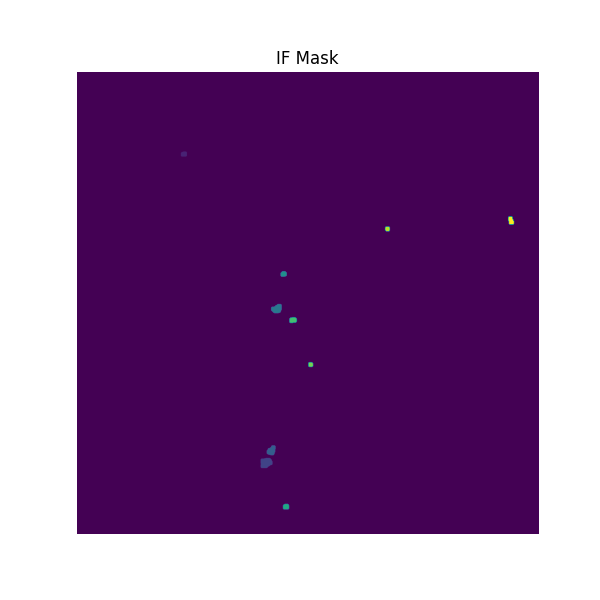

In [126]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
ax.axis('off')
ax.set_title('IF Mask')
_ = ax.imshow(IF_mask_img)

## Load IF data

In [12]:
IF_data_df = pd.read_csv(segmentation_IF_path / 'BP27_Dapi_Table.txt',sep="\t", header=None)
IF_data_df

,0,1,2,3,4
0,1,1265,971,3968,246.2
1,2,2236,4623,14016,491.7
2,3,2301,4478,9024,407.1
3,4,2364,2801,10384,428.9
4,5,2444,2390,4016,250.7
5,6,2473,5142,4224,253.2
6,7,2556,2935,5264,289.9
7,8,2764,3461,2896,207.8
8,9,3673,1856,2896,207.8
9,10,5133,1758,5328,305.6


In [13]:
IF_data_summary_df = pd.read_csv(segmentation_IF_path / 'BP27_Dapi.txt',sep="\t",index_col=0)
IF_data_summary_df

,X,Y,Area,Perimeter
No.,,,,
1,1265.0,971.0,3968.0,246.2
2,2236.0,4623.0,14016.0,491.7
3,2301.0,4478.0,9024.0,407.1
4,2364.0,2801.0,10384.0,428.9
5,2444.0,2390.0,4016.0,250.7
6,2473.0,5142.0,4224.0,253.2
7,2556.0,2935.0,5264.0,289.9
8,2764.0,3461.0,2896.0,207.8
9,3673.0,1856.0,2896.0,207.8


# Analysis

## Registration

## Identify nuclei+ / IF+

In [15]:
nuc_IF_positive = nuclei_masks_img.astype('bool')*IF_mask_img.astype('bool')
label_overlapping_nuclei = nuc_IF_positive*nuclei_masks_img
label_overlapping_IF = nuc_IF_positive*IF_mask_img

In [15]:
np.unique(nuc_IF_positive)

array([False,  True])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
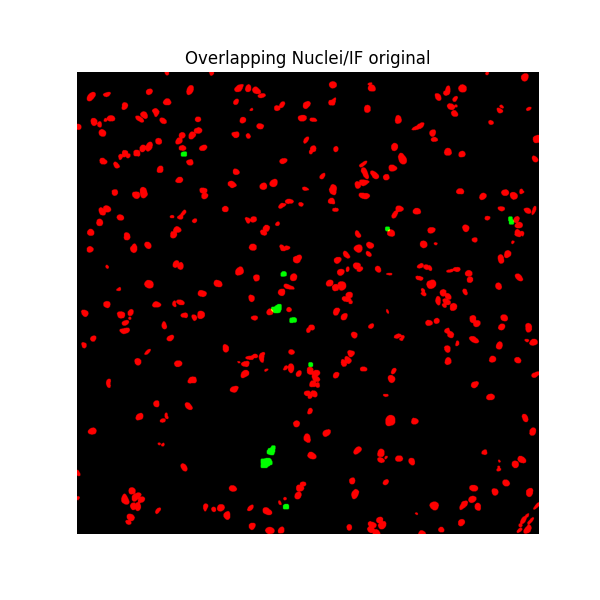

In [148]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
ax.axis('off')
ax.set_title('Overlapping Nuclei/IF original')
img_RGB = np.zeros([nuc_IF_positive.shape[0],nuc_IF_positive.shape[1],3])
img_RGB[:,:,0] = nuclei_masks_img
img_RGB[:,:,1] = IF_mask_img
_ = ax.imshow(img_RGB)

# Simulation

Because the overlapping region of the images is little (probablt for the missing registration) I will run a test on synthetic images based on the nuclei

In [31]:
# create the fake IF image
fake_image_IF = nuclei_masks_img.copy()

# get the number of labels
labels_numbers = np.unique(fake_image_IF)

In [32]:
# Select number of labels to keep
# Good for different testing because you select new cells every time you want to build a new fake image
labels_to_keep = np.random.choice(labels_numbers,size=20)

In [85]:
nuclei_masks_regionprop = measure.regionprops(nuclei_masks_img,extra_properties=None)


In [72]:
fake_image_IF =np.zeros_like(nuclei_masks_img)
for prop in nuclei_masks_regionprop:
    if prop.label in labels_to_keep:
        fake_image_IF[prop.coords[:,0],prop.coords[:,1]] = prop.label
        

In [73]:
fake_image_IF=segmentation.expand_labels(fake_image_IF,distance=30)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
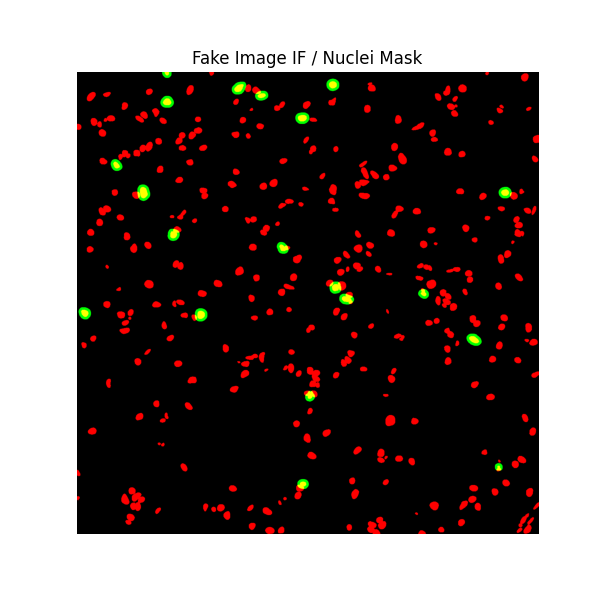

In [74]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
ax.axis('off')
ax.set_title('Fake Image IF / Nuclei Mask')
img_RGB = np.zeros([nuc_IF_positive.shape[0],nuc_IF_positive.shape[1],3])
img_RGB[:,:,0] = nuclei_masks_img
img_RGB[:,:,1] = fake_image_IF
_ = ax.imshow(img_RGB)

In [129]:
# current selection criteria 
# 'remove' = remove the IF mapping on the nucleus that is covering the smallest nucleus
# 'decide' = assign the entire IF data to the nucleus with larger area 
intersection_handling = 'decide' 
overlapping_region = 100

# Determine overlapping nuclei+/IF+ signal
nuc_IF_positive_regions = nuclei_masks_img.astype('bool')*fake_image_IF.astype('bool')
label_overlapping_nuclei = nuc_IF_positive*nuclei_masks_img

# Determine the labels of IF that show some overlapping
labels_overlapping_IF = np.unique(nuc_IF_positive*fake_image_IF)

# Highest label fake_image_IF
starting_add_label = fake_image_IF.max()+1

# Determine which nucleus to select if there is some overlapping
fake_img_regionprops = measure.regionprops(fake_image_IF,extra_properties=None)

matching = []

for prop in fake_img_regionprops:
    if prop.label in labels_overlapping_IF:
        cropped_region = nuclei_masks_img[prop.coords[:,0],prop.coords[:,1]]
        nuclei_labels_in_IF, counts_labels = np.unique(cropped_region,return_counts=True)
        # If the first count is 0 because you are catching the background it needs to be rmeoved
        if nuclei_labels_in_IF[0] == 0:
            nuclei_labels_in_IF = nuclei_labels_in_IF[1:]
            counts_labels = counts_labels[1:]
        # Run processing according to different criteria
        if intersection_handling == 'decide':
            selected_label = nuclei_labels_in_IF[np.where(counts_labels == counts_labels.max())[0]][0]
            matching.append((selected_label,prop.label))
            

In [123]:
# Create image for visualization
final_nuclei_labels = [el[0] for el in matching]
final_IF_labels = [el[1] for el in matching]
removed_overlapped_IF =np.zeros_like(nuclei_masks_img)
removed_overlapped_nuclei = np.zeros_like(nuclei_masks_img)
for prop in nuclei_masks_regionprop:
    if prop.label in final_nuclei_labels:
        removed_overlapped_nuclei[prop.coords[:,0],prop.coords[:,1]] = prop.label

for prop in fake_img_regionprops:
    if prop.label in final_IF_labels:
        removed_overlapped_IF[prop.coords[:,0],prop.coords[:,1]] = prop.label
 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
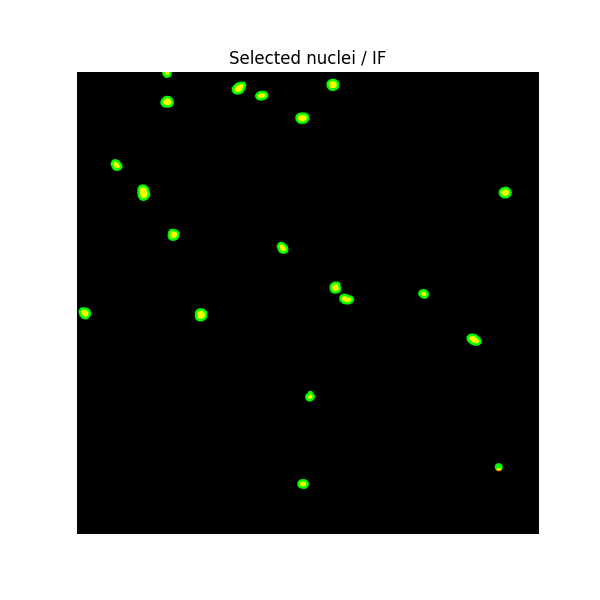

In [149]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
ax.axis('off')
ax.set_title('Selected nuclei / IF')
img_RGB = np.zeros([nuc_IF_positive.shape[0],nuc_IF_positive.shape[1],3])
img_RGB[:,:,0] = removed_overlapped_nuclei
img_RGB[:,:,1] = removed_overlapped_IF
_ = ax.imshow(img_RGB)

In [131]:
excluded_nuclei = ~removed_overlapped_nuclei.astype(bool)*removed_overlapped_IF.astype(bool)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
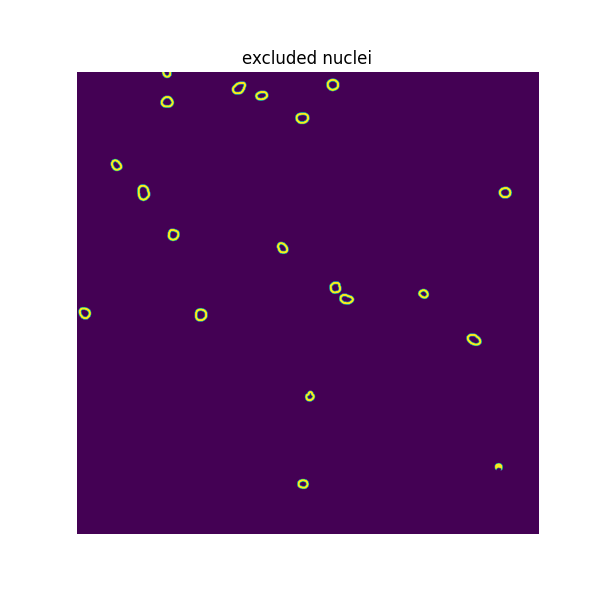

In [132]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
ax.axis('off')
ax.set_title('excluded nuclei')
_ = ax.imshow(excluded_nuclei)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
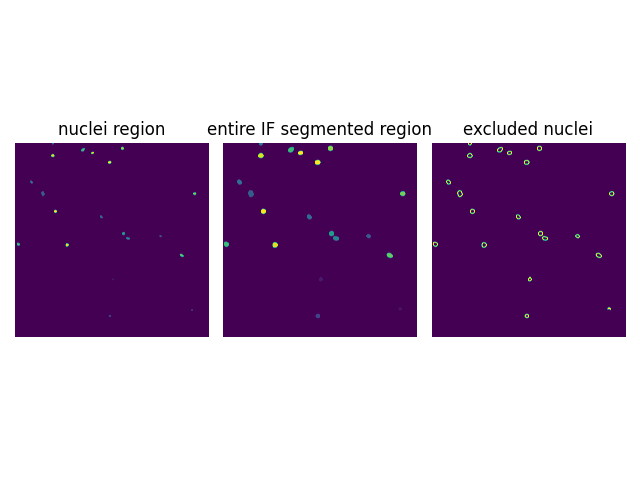

In [147]:
# Masks used to measure in the IF image

fig, axs = plt.subplots(1, 3)

axs[0].axis('off')
axs[0].set_title('nuclei region')
_ = axs[0].imshow(removed_overlapped_nuclei)

axs[1].axis('off')
axs[1].set_title('entire IF segmented region')
_ = axs[1].imshow(removed_overlapped_IF)

axs[2].axis('off')
axs[2].set_title('excluded nuclei')
_ = axs[2].imshow(excluded_nuclei)

plt.tight_layout()